<a href="https://colab.research.google.com/github/DanDas3/reconhecimento-digitos/blob/master/digit_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#coding: utf-8
import cv2 as cv
import numpy as np
import imutils
import os
import keras #Rede Neural
from keras.layers import MaxPooling2D, Flatten, Dense, Dropout
from matplotlib import pyplot as plt
from getpass import getpass
from os import listdir
from os.path import isfile, join

from keras.datasets import mnist
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Dropout, Activation
from keras.utils import np_utils

from sklearn.datasets import fetch_openml
from sklearn.neural_network import MLPClassifier

Using TensorFlow backend.


In [0]:
root = "reconhecimento-digitos"
data_root = "data"
out_path_root = "output"
digits_trains = "cvl-single-digits-train-validation/train"
digits_eval = "cvl-single-digits-train-validation/valid"
digits_valid = "cvl-single-digits-completeDatabase/cvl-single-digits/valid/"
string_trains = "cvl-strings-train/train"
string_eval = "cvl-strings-eval/cvl-strings-eval"

In [0]:
if os.path.exists(root) == False:
  !git clone https://github.com/DanDas3/reconhecimento-digitos.git

In [0]:
# Funções

def converteBin(img):
  max_value = 255
  neighborhood_size=99
  subtract_from_mean = 10
  return cv.adaptiveThreshold(img, max_value, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, neighborhood_size, subtract_from_mean)
  #return cv.threshold(img, 200, 255, cv.THRESH_BINARY)

def GaussianFilter(img):
  return cv.GaussianBlur(img, (5, 5), 0)

def morphologyFilter(img):
  img = cv.threshold(img, 225, 255, cv.THRESH_BINARY_INV)[1]
  img = cv.erode(img, cv.getStructuringElement(cv.MORPH_ELLIPSE, (3, 1)))
  img = cv.dilate(img, cv.getStructuringElement(cv.MORPH_ELLIPSE, (1, 3)))
  return img
def ordenaContornos(cnts):
  for i in range(len(cnts)):
      for j in range(i+1,len(cnts)):
          x_i = cv.boundingRect(cnts[i])[0]
          x_j = cv.boundingRect(cnts[j])[0]

          if(x_j < x_i):
              aux = cnts[j]
              cnts[j] = cnts[i]
              cnts[i] = aux
  return cnts  

def extrairRecortes(img, cnts):
  recorte = []
  copy = img.copy()
  for c in cnts:
    # dados do contorno
    (x, y, w, h) = cv.boundingRect(c)
    if w >= 5 and h >= 17:
      if (w >= 50):  # Divide a região em duas
        copy = cv.rectangle(copy, (x, y), (x + (w // 2), y + h), (0, 255, 0), 2)
        i = copy[y:y + h, x:x + (w // 2)]
        i = cv.resize(i, (32, 32))      
        recorte.append(i)

        i = copy[y:y + h, x + ((w // 2) + 1):x + w]
        copy = cv.rectangle(copy, (x, y), ((x + (w // 2) + 1) + (w // 2), y + h), (0, 255, 0), 2)
        i = cv.resize(i, (32, 32))
        # recorte.append(img[index_img][y:y + h, x + ((w // 2) + 1):x + w])
        recorte.append(i)
      else:
        copy = cv.rectangle(copy, (x, y), (x + w, y + h), (0, 255, 0), 2)
        i = copy[y:y + h, x:x + w]
        i = cv.resize(i, (32, 32))
        # recorte.append(img[index_img][y:y + h, x:x + w])
        recorte.append(i)
  return recorte, copy

def encontraContornos(img):
  cnts = cv.findContours(img.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
  cnts = imutils.grab_contours(cnts)
  cnts = ordenaContornos(cnts)
  return cnts

def marcarSegmentos(img, positions):
  for position in positions:
    cv.rectangle(img, position[0],position[1],(0,0,0),thickness=2)
  return img

def carregaDigitTrain():
  path = root + "/" + data_root + "/" + digits_trains + "/"
  images = [f for f in listdir(path) if isfile(join(path, f))]
  imgBin = 0
  size_vector = 32*32
  data = np.ndarray((len(images), 32, 32, 3))
  data_vector = np.ndarray((len(images), size_vector))
  tags = np.ndarray((len(images), 1))

  for i in range(len(images)):
    img = cv.imread(path + images[i])
    img = cv.resize(img,(32,32))
    imgBin = converteBin(cv.cvtColor(img, cv.COLOR_BGR2GRAY))
    tags[i] = images[i][:1]
    data[i] = img
    data_vector[i] = imgBin.flatten()
  return data, data_vector, tags

def carregaDigitEval():
  path = root + "/" + data_root + "/" + digits_eval + "/"
  images = [f for f in listdir(path) if isfile(join(path, f))]
  imgBin = 0
  size_vector = 32*32
  data = np.ndarray((len(images), 32, 32, 3))
  data_vector = np.ndarray((len(images), size_vector))
  tags = np.ndarray((len(images), 1))
  for i in range(len(images)):
    img = cv.imread(path + images[i])
    img = cv.resize(img,(32,32))
    imgBin = converteBin(cv.cvtColor(img, cv.COLOR_BGR2GRAY))
    tags[i] = images[i][:1]
    data[i] = img
    data_vector[i] = imgBin.flatten()
  return data, data_vector, tags

def carregaDigitValid():
  path = root + "/" + data_root + "/" + digits_valid + "/"
  images = [f for f in listdir(path) if isfile(join(path, f))]
  imgBin = 0
  size_vector = 32*32
  data = np.ndarray((len(images), 32, 32, 3))
  data_vector = np.ndarray((len(images), size_vector))
  tags = np.ndarray((len(images), 1))
  for i in range(len(images)):
    img = cv.imread(path + images[i])
    img = cv.resize(img,(32,32))
    imgBin = converteBin(cv.cvtColor(img, cv.COLOR_BGR2GRAY))
    tags[i] = images[i][:1]
    data[i] = img
    data_vector[i] = imgBin.flatten()
  return data, data_vector, tags

def carregaStringsValid():
  path = root + "/" + data_root + "/" + string_eval + "/"
  images = [f for f in listdir(path) if isfile(join(path, f))]
  #data = np.ndarray((len(images), 365, 32, 3))
  #tags = np.ndarray((len(images), 1))
  data = []
  digits = []
  for i in range(len(images)):
    img = cv.imread(path + images[i],0)
    #img = cv.resize(img,(365,89))    
    tag_num = images[i].split("-",1)[0]
    for j in range(len(tag_num)):
      digits.append(tag_num[j])
    data.append((img, digits))  
    #tags[i] = int(tag_num)
    #data[i] = img
  
  return data

In [6]:
data_train, x_train, tag_train = carregaDigitTrain()

data_eval, x_eval, tag_eval = carregaDigitEval()

data_valid, x_valid, tag_valid = carregaDigitValid()

print(type(tag_train))
print(type(tag_train[0]))
print(tag_train[0])

string_digits=carregaStringsValid()

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
[5.]


In [0]:
#Normaliza
x_train /= 255
x_eval /= 255
x_valid /= 255

In [8]:
# Organiza a categoria
num_classes = len(np.unique(tag_train))
print("Número de classes:", num_classes)

tag_train = keras.utils.to_categorical(tag_train, num_classes)
tag_valid = keras.utils.to_categorical(tag_valid, num_classes)
tag_eval = keras.utils.to_categorical(tag_eval, num_classes)

Número de classes: 10


In [0]:
img = string_digits[0][0]

blur = GaussianFilter(img)

binImg = morphologyFilter(blur)

cnts = encontraContornos(binImg)

cnts = ordenaContornos(cnts)

marcado, recortes = marcarSegmentos(img, cnts)

#recortes = extrairRecortes(img, cnts)
#print(len(recortes))

fig,axes = plt.subplots(5, 1, figsize=(15, 5))
ax = axes.ravel()

ax[0].imshow(cv.cvtColor(img, cv.COLOR_GRAY2BGR))
ax[0].set_title("Imagem Original")
ax[0].set_axis_off()

ax[1].imshow(cv.cvtColor(blur, cv.COLOR_GRAY2BGR))
ax[1].set_title("Filtro Gaussiano")
ax[1].set_axis_off()

ax[2].imshow(binImg)
ax[2].set_title("Imagem Binarizada")
ax[2].set_axis_off()

ax[3].imshow(cv.cvtColor(marcado, cv.COLOR_BGR2RGB))
ax[3].set_title("Segmentos Marcados")
ax[3].set_axis_off()

#ax[4].imshow(cv.cvtColor(recortes[0], cv.COLOR_BGR2RGB))
ax[4].set_title("Recorte")
ax[4].set_axis_off()

SystemError: ignored

# Teste Rede Neural

In [9]:
# Modelagem da MLP
mlp = Sequential()
mlp.add(Dense(512, input_shape=(1024,))) # entrada com imagens 32x32 -> vetor de 1024 posições, primeira camada com 512 neurônios
mlp.add(Activation("relu"))
mlp.add(Dropout(0.2))

mlp.add(Dense(512))
mlp.add(Activation("relu"))
mlp.add(Dropout(0.2))

mlp.add(Dense(10)) # Saída com 10 posições referentes as classes
mlp.add(Activation("softmax"))
mlp.add(Dropout(0.2))

mlp.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
activation_2 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_

In [10]:
# Compilando
mlp.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 7000 samples, validate on 7000 samples
Epoch 1/10





 - 2s - loss: 3.7227 - acc: 0.6217 - val_loss: 0.5435 - val_acc: 0.8250

Epoch 00001: val_loss improved from inf to 0.54354, saving model to model.weights.best.hdf5
Epoch 2/10
 - 0s - loss: 3.4890 - acc: 0.7099 - val_loss: 0.4033 - val_acc: 0.8787

Epoch 00002: val_loss improved from 0.54354 to 0.40335, saving model to model.weights.best.hdf5
Epoch 3/10
 - 0s - loss: 3.4779 - acc: 0.7276 - val_loss: 0.4311 - val_acc: 0.8674

Epoch 00003: val_loss did not improve from 0.40335
Epoch 4/10
 - 0s - loss: 3.3497 - acc: 0.7403 - val_loss: 0.3880 - val_acc: 0.8836

Epoch 00004: val_loss improved from 0.40335 to 0.38805, saving model to model.weights.best.hdf5
Epoch 5/10
 - 0s - loss: 3.2160 - acc: 0.7569 - val_loss: 0.3637 - val_acc: 0.8930

Epoch 00005: val_loss improved from 0.38805 to 0.36375, saving model to model.weights.best.hdf5

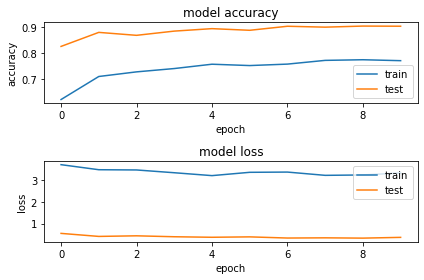

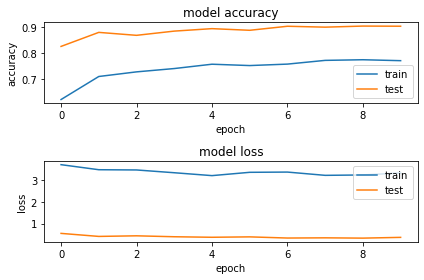

In [11]:
#Treinamento

# Salva os melhores resultados
from keras.callbacks import ModelCheckpoint   
checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, save_best_only=True)

history = mlp.fit(x_train, tag_train, 128, epochs=10, validation_data=(x_valid, tag_valid), verbose=2, callbacks=[checkpointer])

# plotting the metrics
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()

fig

In [0]:
# Carrega o modelo com os melhores valores
mlp.load_weights('model.weights.best.hdf5')

In [13]:
# Avalia os resultados
# evaluate and print test accuracy
score = mlp.evaluate(x_eval, tag_eval, verbose=2)

print('\n', 'Test accuracy:', score[1])
print("Test loss", score[0])


 Test accuracy: 0.9028571427890233
Test loss 0.3241783157331603


In [14]:
# Predições

predict = mlp.predict(x_eval)

labels = [str(i) for i in range(10)]

print(labels)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


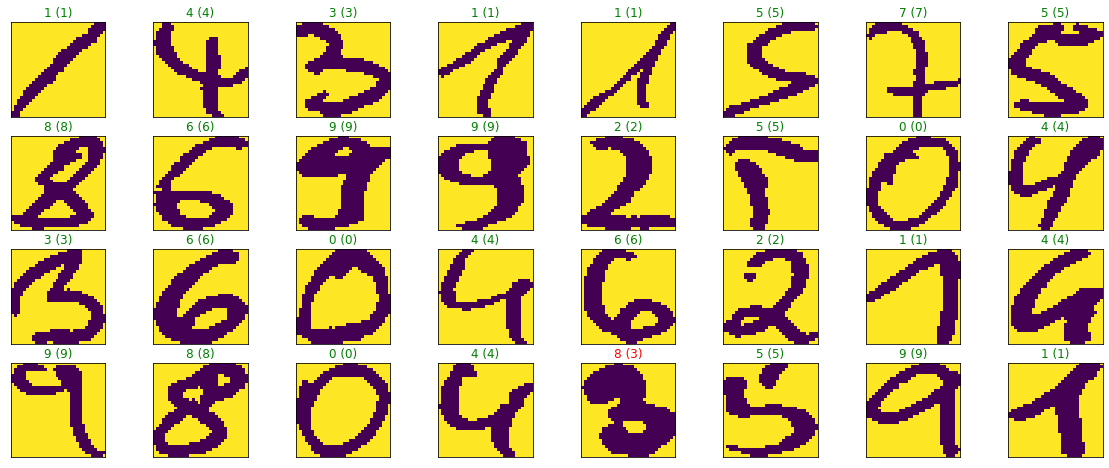

In [15]:
# plot a random sample of test images, their predicted labels, and ground truth
fig = plt.figure(figsize=(20, 8))
for i, idx in enumerate(np.random.choice(x_eval.shape[0], size=32, replace=False)):
    ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_eval[idx].reshape(32,32)))
    pred_idx = np.argmax(predict[idx])
    true_idx = np.argmax(tag_eval[idx])
    ax.set_title("{} ({})".format(labels[pred_idx], labels[true_idx]),
                 color=("green" if pred_idx == true_idx else "red"))

In [0]:
# Salva dados do modelo no pc
from google.colab import files

files.download("model.weights.best.hdf5")


0  classified correctly
1  classified incorrectly


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  after removing the cwd from sys.path.


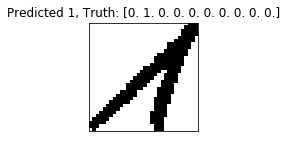

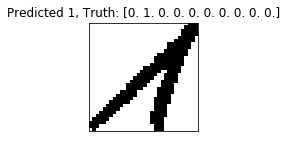

In [21]:
# see which we predicted correctly and which not
predicted_classes = mlp.predict_classes(x_eval)

correct_indices = np.nonzero(predicted_classes == tag_eval)[0]
incorrect_indices = np.nonzero(predicted_classes != tag_eval)[0]
print()
print(len(correct_indices)," classified correctly")
print(len(incorrect_indices)," classified incorrectly")

# adapt figure size to accomodate 18 subplots
plt.rcParams['figure.figsize'] = (7,14)

figure_evaluation = plt.figure()

# plot 9 correct predictions
for i, correct in enumerate(correct_indices[:9]):
    plt.subplot(6,3,i+1)
    plt.imshow(x_eval[correct].reshape(32,32), cmap='gray', interpolation='none')
    plt.title(
      "Predicted: {}, Truth: {}".format(predicted_classes[correct],
                                        tag_eval[correct]))
    plt.xticks([])
    plt.yticks([])

# plot 9 incorrect predictions
for i, incorrect in enumerate(incorrect_indices[:9]):
    plt.subplot(6,3,i+10)
    plt.imshow(x_eval[incorrect].reshape(32,32), cmap='gray', interpolation='none')
    plt.title(
      "Predicted {}, Truth: {}".format(predicted_classes[incorrect], 
                                       tag_eval[incorrect]))
    plt.xticks([])
    plt.yticks([])

figure_evaluation

In [0]:
#Rede Neural
from keras.datasets import imdb
from keras.preprocessing.text import Tokenizer
from keras import models
from keras import layers

# Set random seed
np.random.seed(0)

# Set the number of features we want
number_of_features = 1000

# Load data and target vector from movie review data
(data_train, target_train), (data_test, target_test) = imdb.load_data(
num_words=number_of_features)

In [0]:
# Divide em treinamento, teste e validação
(data_train, data_valid) = data_train[number_of_features//2:], data_train[:number_of_features//2]
(target_train, target_valid) = target_train[number_of_features//2:], target_train[:number_of_features//2]
# Convert movie review data to one-hot encoded feature matrix
tokenizer = Tokenizer(num_words=number_of_features//2)
features_train = tokenizer.sequences_to_matrix(data_train, mode="binary")
features_valid = tokenizer.sequences_to_matrix(data_valid, mode="binary")

data_test = data_test[:500]
target_test = target_test[:500]
tokenizer = Tokenizer(num_words=number_of_features//2)
features_test = tokenizer.sequences_to_matrix(data_test, mode="binary")

In [0]:
# Start neural network
network = models.Sequential()

# Add fully connected layer with a ReLU activation function
network.add(layers.Dense(units=16, activation="relu", input_shape=(number_of_features//2,)))

# Add fully connected layer with a ReLU activation function
network.add(layers.Dense(units=16, activation="relu"))

# Add fully connected layer with a sigmoid activation function
network.add(layers.Dense(units=1, activation="sigmoid"))

In [0]:
# Compile neural network
network.compile(loss="binary_crossentropy", # Cross-entropy
optimizer="rmsprop", # Root Mean Square Propagation
metrics=["accuracy"]) # Accuracy performance metric

In [0]:
# Train neural network

from keras.callbacks import ModelCheckpoint   

# Salva o melhor resultado
checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, save_best_only=True)

history = network.fit(features_train, # Features
target_train, # Target vector
epochs=20, # Number of epochs
verbose=2, # Print description after each epoch
batch_size=10, # Number of observations per batch
validation_data=(features_valid, target_valid), # Validation data
callbacks=[checkpointer],
shuffle=True)

Train on 24500 samples, validate on 500 samples
Epoch 1/20
 - 7s - loss: 0.3699 - acc: 0.8433 - val_loss: 0.3579 - val_acc: 0.8420

Epoch 00001: val_loss improved from inf to 0.35786, saving model to model.weights.best.hdf5
Epoch 2/20
 - 7s - loss: 0.3627 - acc: 0.8460 - val_loss: 0.3538 - val_acc: 0.8320

Epoch 00002: val_loss improved from 0.35786 to 0.35381, saving model to model.weights.best.hdf5
Epoch 3/20
 - 8s - loss: 0.3547 - acc: 0.8524 - val_loss: 0.3785 - val_acc: 0.8400

Epoch 00003: val_loss did not improve from 0.35381
Epoch 4/20
 - 8s - loss: 0.3470 - acc: 0.8577 - val_loss: 0.3731 - val_acc: 0.8340

Epoch 00004: val_loss did not improve from 0.35381
Epoch 5/20
 - 8s - loss: 0.3397 - acc: 0.8637 - val_loss: 0.4094 - val_acc: 0.8420

Epoch 00005: val_loss did not improve from 0.35381
Epoch 6/20
 - 8s - loss: 0.3330 - acc: 0.8682 - val_loss: 0.3988 - val_acc: 0.8240

Epoch 00006: val_loss did not improve from 0.35381
Epoch 7/20
 - 7s - loss: 0.3242 - acc: 0.8719 - val_loss

In [0]:
# Carrega os pesos com melho precisão na validação
network.load_weights('model.weights.best.hdf5')

In [0]:
print(features_test.shape)
print(features_test[0].shape)
print(features_test[0:1].shape)

(500, 500)
(500,)
(1, 500)


In [0]:
# Avaliaçãão do treinamento
score = network.evaluate(features_test, target_test, verbose=0)
print("\n","Resultado:", score[1])


 Resultado: 0.8400000009536743


In [0]:
y_hat = network.predict(features_test)

In [0]:
print(type(data_test[0]))
print(type(target_test[0]))
print(target_test[2])
for i, idx in enumerate(np.random.choice(features_test.shape[0], size=32, replace=False)):
  pred_idx = np.argmax(y_hat[idx])
  true_idx = np.argmax(data_test[idx])

  print(data_test[true_idx] == data_test[pred_idx] )

<class 'list'>
<class 'numpy.int64'>
1
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


# MLP Classifier

In [0]:
# Load data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X / 255.

X data: <class 'numpy.ndarray'> Y tag: <class 'numpy.ndarray'>
(1024,)
<class 'numpy.ndarray'>
[5.]
Iteration 1, loss = 2.38463694


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:921: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 2, loss = 1.83562964
Iteration 3, loss = 1.59832445
Iteration 4, loss = 1.53539775
Iteration 5, loss = 1.60023901
Iteration 6, loss = 1.41306593
Iteration 7, loss = 1.48656981
Iteration 8, loss = 1.43290314
Iteration 9, loss = 1.69769646
Iteration 10, loss = 1.96423213
Training set score: 0.232286
Test set score: 0.219857


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


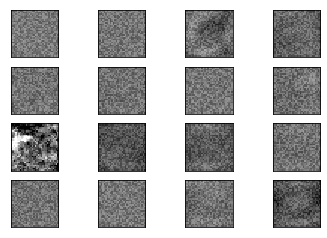

In [38]:
#print(__doc__)

# rescale the data, use the traditional train/test split
#X_train, X_test = X[:60000], X[60000:]
#y_train, y_test = y[:60000], y[60000:]

X_train, X_test = x_train, x_eval
y_train, y_test = tag_train, tag_eval


print("X data:",type(X_train), "Y tag:", type(X_test))
print(X_train[0].shape)
print(type(y_train[0]))
print(y_train[0])
# mlp = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=400, alpha=1e-4,
#                     solver='sgd', verbose=10, tol=1e-4, random_state=1)
mlp = MLPClassifier(hidden_layer_sizes=(50,), max_iter=10, alpha=1e-4,
                    solver='sgd', verbose=10, tol=1e-4, random_state=1,
                    learning_rate_init=.1)

mlp.fit(X_train/255, y_train)
print("Training set score: %f" % mlp.score(X_train/255, y_train))
print("Test set score: %f" % mlp.score(X_test/255, y_test))

fig, axes = plt.subplots(4, 4)
# use global min / max to ensure all weights are shown on the same scale
vmin, vmax = mlp.coefs_[0].min(), mlp.coefs_[0].max()
for coef, ax in zip(mlp.coefs_[0].T, axes.ravel()):
    ax.matshow(coef.reshape(32, 32), cmap=plt.cm.gray, vmin=.5 * vmin,
               vmax=.5 * vmax)
    ax.set_xticks(())
    ax.set_yticks(())

plt.show()